# Library and Package installation
- biopython
- scipy 
- matplotlib
- numpy 
conda install <pakage>

In [36]:
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import numpy as np
import math
import matplotlib
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from RamachanDraw import phi_psi
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy

In [24]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [25]:
# Set path to a fodler for input/output data
# Change here according to your setup
#path = 'drive/My Drive/structural_bioinformatics/Homework1/data'

#import os
#if os.path.exists(path +'/figures') is False:
  #os.mkdir(path +'/figures')

#Parsing 
- id_protein =  1uf5_A Crystal structure of C171A/V236A Mutant of N-carbamyl-D-amino acid amidohydrolase complexed with N-carbamyl-D-methionine


In [26]:
path = "."
id_protein = '1uf5'

In [27]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(id_protein, pdir= path + "/pdb", file_format='pdb')  # Will save a pdbXXXX.ent file

Structure exists: './pdb/pdb1uf5.ent' 


'./pdb/pdb1uf5.ent'

In [28]:
structure = PDBParser(QUIET=True).get_structure(id_protein, path + "/pdb/pdb{}.ent".format(id_protein))

# Distance matrix
Structure with id “1abc” Model with id 0 Chain with id “A” Residue with id (” “, 10, “A”)

The Residue id indicates that the residue is not a hetero-residue (or a water) because it has a blank hetero field, that its sequence identifier is 10 and its insertion code “A”.

In [29]:
def get_distance_matrix(residues, seq_sep):
  distances = []
  for residue1 in residues:
    row = []
    #if the residue is not a glycine, use CB atom or CA atom if the second residue is a glycine
    if residue1.resname != "GLY":  
      for residue2 in residues:
        if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
          if residue2.resname != "GLY":
            row.append(abs(residue1["CA"] - residue2["CA"]))
          else:
            row.append(abs(residue1["CB"] - residue2["CA"]))
        else: 
          row.append(None)
      distances.append(row)
    else:
      for residue2 in residues: 
        if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
          row.append(abs(residue1["CA"] - residue2["CA"]))
        else:
          row.append(None)
      distances.append(row)
  return np.array(distances, dtype=float)

In [30]:
selected_residues = [residue for residue in structure[0]['A'] if residue.id[0] == " "] 

In [31]:
distance_matrix = get_distance_matrix(selected_residues, 5)

/tmp/ipykernel_24439/1321710133.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap())


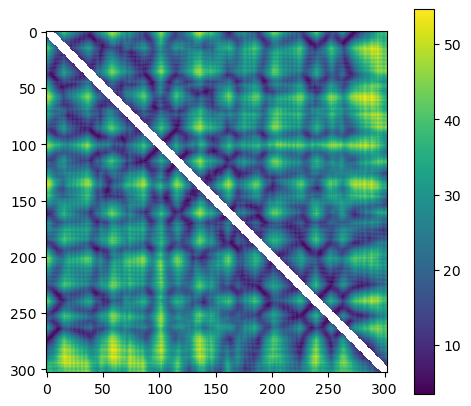

In [32]:
# Alter the color map to highlight 
current_cmap = copy.copy(matplotlib.cm.get_cmap())
current_cmap.set_bad(color='k')

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(distance_matrix)
fig.colorbar(im, fraction=0.05, pad=0.07)
plt.savefig(path + '/figures/ca_distances_{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

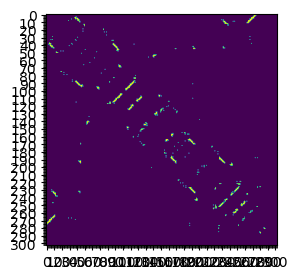

In [33]:
contact_map = (distance_matrix[:] < 7).astype(float)  
# Plot contact map
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

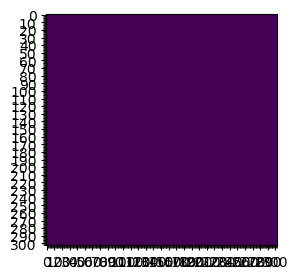

In [34]:
contact_map1 = (distance_matrix[:] < 14).astype(float)
contact_map = (contact_map1[:] > 7).astype(float)
# Plot contact map
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}1.png'.format(id_protein), dpi=300, bbox_inches='tight')

In [ ]:
phi_psi(pdb_file, return_ignored)